# Тестовое задание
 
В прикрепленном файле data_train.csv вам предоставлены почасовые данные потребления электроэнергии одного из предприятий (c 1.01.2019 по 8.09.2019). Постройте почасовой прогноз потребления с 9.09.2019 по 22.09.2019. В качестве метрики используйте RMSE. Оформите на языке Python в Jupyter Notebook выбор модели, подбор параметров и построение прогноза. Можно пользоваться любыми библиотеками. Также, предоставьте файл с прогнозами в формате csv. 

In [37]:
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
from itertools import product
from warnings import filterwarnings
from tqdm import tqdm
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
filterwarnings('ignore')

In [38]:
ts = pd.read_csv('data_train_NNFormat.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
ts.head()

,fact
timestamp,
2019-01-01 00:00:00,294.0
2019-01-01 01:00:00,292.0
2019-01-01 02:00:00,290.0
2019-01-01 03:00:00,293.0
2019-01-01 04:00:00,294.0


In [39]:
train_st, train_end = '20190101','20190825'
test_st, test_end = '20190826', '20190908'
holidays = [f'010{i}' for i in range(1, 9)] + ['0223', '0308', '0501', '0509', '0612']
holidays = ['2019' + h for h in holidays]

In [40]:
ts['holiday'] = 0
for h in holidays:
    ts[h]['holiday'] = 1
ts['month'] = ts.index.month
ts['dayofweek'] = ts.index.dayofweek
ts['dayofmonth'] = ts.index.day
ts['dayofyear'] = ts.index.dayofyear
ts['hour'] = ts.index.hour
ts['weekofyear'] = ts.index.weekofyear
ts['quarter'] = ts.index.quarter

In [41]:
train_ts, test_ts = ts[:train_end], ts[test_st:]
X_train, X_test = train_ts.drop(columns=['fact']), test_ts.drop(columns=['fact'])
y_train, y_test = train_ts['fact'], test_ts['fact']

In [42]:
%%time
xgb_model = XGBRegressor(n_estimators=1000, gpu_id=0)
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train)], early_stopping_rounds=50, verbose=False)

Wall time: 1.72 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

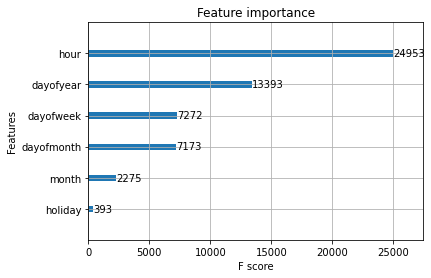

In [43]:
plot_importance(xgb_model)

63.593188604006706

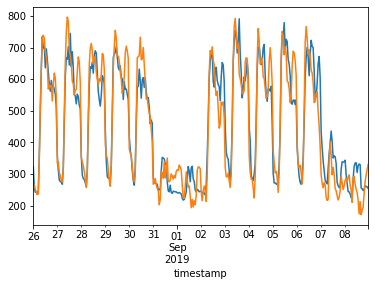

In [44]:
test_ts['xgb'] = xgb_model.predict(X_test)
test_ts['fact'].plot()
test_ts['xgb'].plot()
mean_squared_error(test_ts['fact'], test_ts['xgb'], squared=False)

In [45]:
params = {
    'n_estimators': [100, 700, 1000, 1500],
    'max_depth': [3, 6, 10, 15],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 1, 1.2],
    'reg_lambda': [0, 1, 1.2],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
}

In [46]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

cv = 5
xgb_model = XGBRegressor(gpu_id=0)
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=params, scoring = 'neg_mean_squared_error', n_jobs = 10, 
                        cv = TimeSeriesSplit(n_splits=cv).get_n_splits([X_train, y_train]))
xgb_grid.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50)
xgb_grid.best_params_

[0]	validation_0-rmse:336.55020
[1]	validation_0-rmse:233.38441
[2]	validation_0-rmse:162.29443
[3]	validation_0-rmse:117.28389
[4]	validation_0-rmse:87.49212
[5]	validation_0-rmse:68.40110
[6]	validation_0-rmse:55.30030
[7]	validation_0-rmse:48.26180
[8]	validation_0-rmse:44.44014
[9]	validation_0-rmse:42.99498
[10]	validation_0-rmse:41.66932
[11]	validation_0-rmse:41.69189
[12]	validation_0-rmse:41.63357
[13]	validation_0-rmse:42.70095
[14]	validation_0-rmse:42.87022
[15]	validation_0-rmse:43.17593
[16]	validation_0-rmse:42.98031
[17]	validation_0-rmse:43.01023
[18]	validation_0-rmse:43.50296
[19]	validation_0-rmse:43.71528
[20]	validation_0-rmse:44.22942
[21]	validation_0-rmse:43.97993
[22]	validation_0-rmse:44.01481
[23]	validation_0-rmse:44.07703
[24]	validation_0-rmse:44.52616
[25]	validation_0-rmse:44.77523
[26]	validation_0-rmse:45.09614
[27]	validation_0-rmse:45.19953
[28]	validation_0-rmse:45.19694
[29]	validation_0-rmse:45.20878
[30]	validation_0-rmse:45.20201
[31]	validatio

{'colsample_bytree': 1,
 'gamma': 0,
 'max_depth': 6,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.9}

41.633571495492866

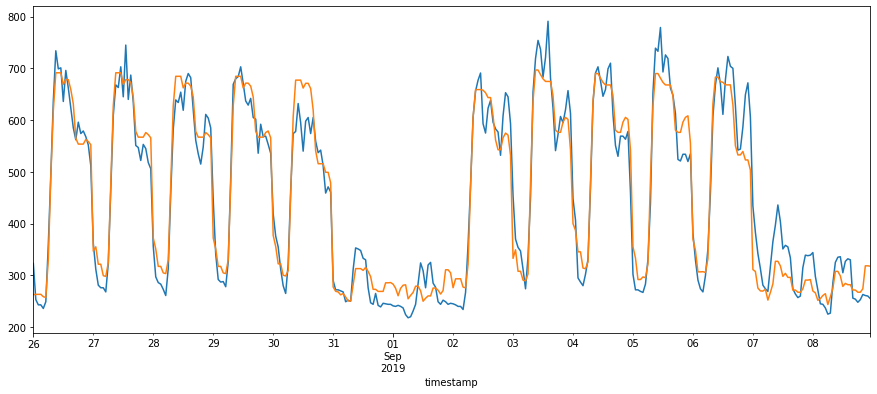

In [53]:
plt.figure(figsize=(15, 6))
test_ts['xgb'] = xgb_grid.best_estimator_.predict(X_test)
test_ts['fact'].plot()
test_ts['xgb'].plot()
mean_squared_error(test_ts['fact'], test_ts['xgb'], squared=False)

<AxesSubplot:xlabel='timestamp'>

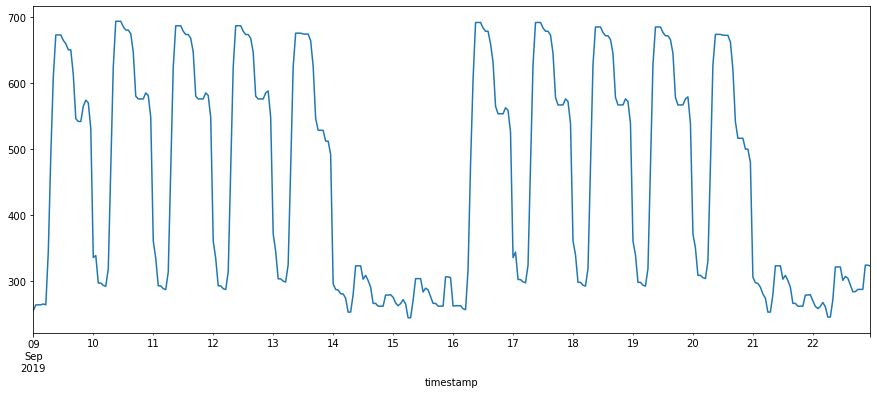

In [49]:
forecast_ts = pd.DataFrame({'timestamp':pd.date_range('2019-09-09', '2019-09-23', freq='1H', closed='left')})
forecast_ts.set_index('timestamp', inplace=True)
forecast_ts['holiday'] = 0
forecast_ts['month'] = forecast_ts.index.month
forecast_ts['dayofweek'] = forecast_ts.index.dayofweek
forecast_ts['dayofmonth'] = forecast_ts.index.day
forecast_ts['dayofyear'] = forecast_ts.index.dayofyear
forecast_ts['hour'] = forecast_ts.index.hour
forecast_ts['weekofyear'] = forecast_ts.index.weekofyear
forecast_ts['quarter'] = forecast_ts.index.quarter
forecast_ts['xgb'] = xgb_grid.best_estimator_.predict(forecast_ts)
forecast_ts['xgb'].plot(figsize=(15, 6))

In [50]:
forecast_ts['xgb'].to_csv("predictions_0909_0922.csv")